In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [2]:
!pip install shap
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
import tensorflow as tf
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.7 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
x_train = np.load('/content/gdrive/My Drive/Whanganui/x_train.npy')
y_train = np.load('/content/gdrive/My Drive/Whanganui/y_train.npy')
x_test = np.load('/content/gdrive/My Drive/Whanganui/x_test.npy')
y_test = np.load('/content/gdrive/My Drive/Whanganui/y_test.npy')
x_val = np.load('/content/gdrive/My Drive/Whanganui/x_val.npy')
y_val = np.load('/content/gdrive/My Drive/Whanganui/y_val.npy')


In [4]:
tf.random.set_seed(1)
model = models.Sequential()
tf.keras.backend.clear_session()
model.add(layers.Dense(10, activation = 'relu', input_shape = (x_train.shape[1], )))
model.add(layers.Dense(10,activation = 'relu')),
model.add(layers.Dense(1,))
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss = 'mse', metrics = ['mse'])
reuslt = model.fit(x_train,y_train,epochs = 1000,batch_size = 300, verbose = 0)
y_test_predict = model.predict(x_test)   ##The optimal values for the hyperparameters might be different

2/2 [==============================] - 0s 7ms/step


0.12177094007880708
0.6930822371332573


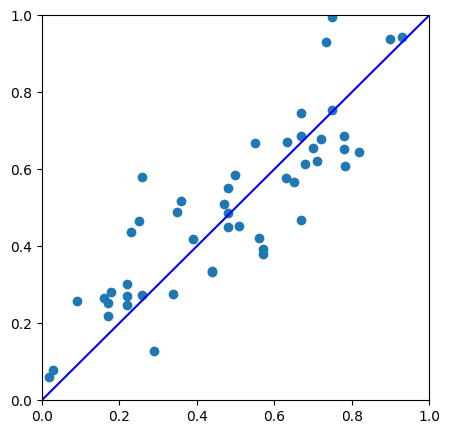

In [6]:
plt.figure(figsize=[5,5])
plt.scatter(y_test,y_test_predict)
xx = [0,1]
yy = [0,1]
plt.plot(xx,yy,'b-')
plt.xlim([0,1])
plt.ylim([0,1])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
print(math.sqrt(mean_squared_error(y_test_predict.flatten(),y_test.flatten())))
print(r2_score(y_test_predict,y_test))  ##R2 and MSE might be a bit differet because the random seed here is different..

##I skipped some steps to tune the model (because I found it barely affected the results and it took a huge amount of time to finish)

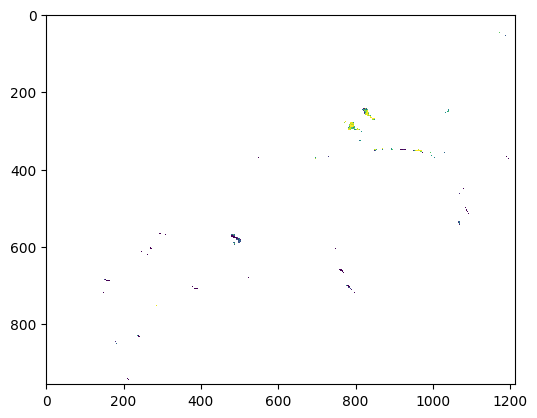

In [11]:
classification_map = cv2.imread('/content/gdrive/My Drive/Whanganui/sc20211231.tif',-1)
seagrass_clip = np.where(classification_map>=3,np.nan,classification_map) ##only keep seagrass
plt.imshow(seagrass_clip)

In [13]:
###Apply the model
from osgeo import gdal
YG_dataset = gdal.Open('/content/gdrive/My Drive/Whanganui/Rrs20230727_cl_re.tif')
YG_width = YG_dataset.RasterXSize
print(YG_width)
YG_height = YG_dataset.RasterYSize
print(YG_height)
YG_geotrans = YG_dataset.GetGeoTransform()
print(YG_geotrans)
YG_proj = YG_dataset.GetProjection()
print(YG_proj)
YG_data = YG_dataset.ReadAsArray(0, 0, YG_width, YG_height)
Band2 = YG_data[0,0:YG_height,0:YG_width]
Band2 = np.array(np.where(Band2<0,np.nan,Band2))
Band2 = Band2*seagrass_clip
Band3 = YG_data[1,0:YG_height,0:YG_width]
Band3 = np.array(np.where(Band3<0,np.nan,Band3))
Band3 = Band3*seagrass_clip
Band4 = YG_data[2,0:YG_height,0:YG_width]
Band4 = np.array(np.where(Band4<0,np.nan,Band4))
Band4 = Band4*seagrass_clip
Band8 = YG_data[3,0:YG_height,0:YG_width]
Band8 = np.array(np.where(Band8<0,np.nan,Band8))
Band8 = Band8*seagrass_clip

1214
956
(626310.0, 10.0, 0.0, 5509610.0, 0.0, -10.0)
PROJCS["WGS 84 / UTM zone 59S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32759"]]


In [14]:
NDVI = (Band8-Band4)/(Band8+Band4)
NDVI = np.where(NDVI==0,np.nan,NDVI)
NDWI = (Band3-Band8)/(Band3+Band8)
NDWI = np.where(NDWI==0,np.nan,NDWI)

In [ ]:
##Calculate the percentage cover of seagrass in each cover

In [ ]:
percent = []
processed_elements = 0
total_elements = np.shape(Band2)[0]*np.shape(Band2)[1]
for i in range(len(Band2)):
  result = []
  percent.append(result)
  for j in range(len(Band2[i])):
    if np.isnan(Band2[i][j]) == True:
      Y = np.nan
      result.append(Y)
    else:
      X = np.array([[Band2[i,j],Band3[i,j],Band4[i,j],Band8[i,j],NDVI[i,j],NDWI[i,j]],
            [Band2[i,j],Band3[i,j],Band4[i,j],Band8[i,j],NDVI[i,j],NDWI[i,j]]])
      Y = model.predict(X)[0][0]
      result.append(Y)
    processed_elements += 1
    progress_percentage = (processed_elements / total_elements) * 100
    print(f"Progress: {progress_percentage:.2f}%")
plt.imshow(percent)

In [ ]:
percent = np.array(percent)
raster = gdal.Open('/content/gdrive/My Drive/Whanganui/Rrs20230727_cl_re.tif')
geot = raster.GetGeoTransform()
proj = raster.GetProjectionRef()
filename = '/content/gdrive/My Drive/Whanganui/seagrass_percentage_20230727.tif' ##where you want to save
xsize = np.shape(Band2)[1]
ysize = np.shape(Band2)[0]
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(filename, xsize, ysize,1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(percent)
dataset.SetGeoTransform(geot)
dataset.SetProjection(proj)